# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import stencil_calculator as sc
%matplotlib inline
import time, os

Here, I will show some examples on how you can use the findiff package to take numerical derivatives of functions.

# 1st example - Toy model

For the first example, let's take derivatives of the following function:

$$
f(x,a,b)=\sin(x\,a)\cos(x\,b)\;,
$$

with respect to $a$ and $b$. The function is defined in a .py called my_functions.py. NumDe is compatible with multiprocessing, and to use it you must define a function in a separate file and import it.

In [2]:
x_array = np.arange(-10,10,0.01)
def function_test(theta,kwargs):
    return np.sin(kwargs["x_array"]*theta[0]) * np.cos(kwargs["x_array"]*theta[1])


In [3]:
import numerical_derivative as nd

We can inizialize the FiniteDerivative method in the following way:

In [4]:
ND_obj = nd.FiniteDerivative()

In [5]:
N_taylor = 4 #The code will compute derivatives up to this order
N_grid = 6 #The size of the stencil will be 2*N_grid + 1

#These are the specifications for the grid. The first value is the reference one, and the second is the step
#size in units of the reference values. 

# Example: If "x":[x0, x_percentage], the grid spacing will be x0*x_percentage

expansion_table = {
    "a":[-1, 0.1],
    "b":[1,  0.1]
}

ND_obj.define_setup(N_taylor,N_grid, expansion_table)

Now, we compute the function in the total grid defined above. First, without the multiprocessing:

In [6]:
ND_obj.processes = False
start_time = time.time()
ND_obj.evaluate_in_grid(function_test, x_array=x_array)
end_time = time.time()
print("Time without multiprocessing: ", end_time - start_time)

Time without multiprocessing:  0.02903890609741211


Now, to take the derivatives:

In [7]:
ND_obj.take_derivative_ALL(verbose=False)

{'d1a': {'02': array([-5.924301  , -5.99691814, -6.0687145 , ...,  6.13966101,
          6.0687145 ,  5.99691814]),
  '04': array([-6.83209683, -6.91415975, -6.99523695, ...,  7.07529565,
          6.99523695,  6.91415975]),
  '06': array([-6.99902149, -7.08251266, -7.16498173, ...,  7.24639543,
          7.16498173,  7.08251266]),
  '08': array([-7.03190787, -7.11561972, -7.19830136, ...,  7.27991943,
          7.19830136,  7.11561972]),
  '10': array([-7.03862689, -7.12237145, -7.20508399, ...,  7.28673114,
          7.20508399,  7.12237145]),
  '12': array([-7.04003085, -7.12377967, -7.20649605, ...,  7.28814666,
          7.20649605,  7.12377967])},
 'd1b': {'02': array([-2.49040885, -2.41238448, -2.33517248, ...,  2.25880193,
          2.33517248,  2.41238448]),
  '04': array([-2.87202059, -2.78136391, -2.6916878 , ...,  2.60302505,
          2.6916878 ,  2.78136391]),
  '06': array([-2.942191  , -2.84908735, -2.75700366, ...,  2.66597324,
          2.75700366,  2.84908735]),
  '0

And thats it! Lets plot the results:

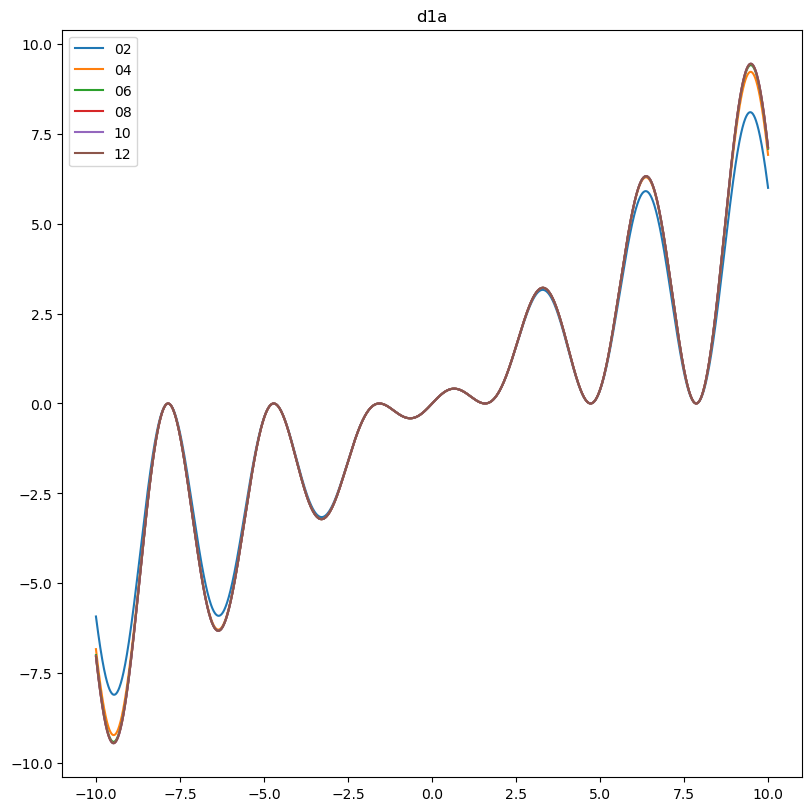

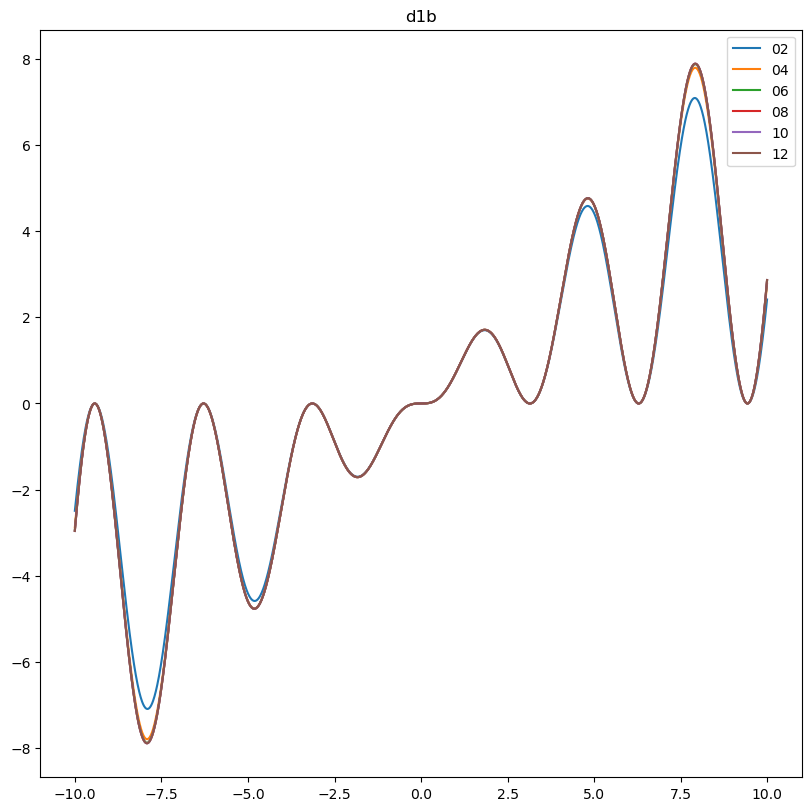

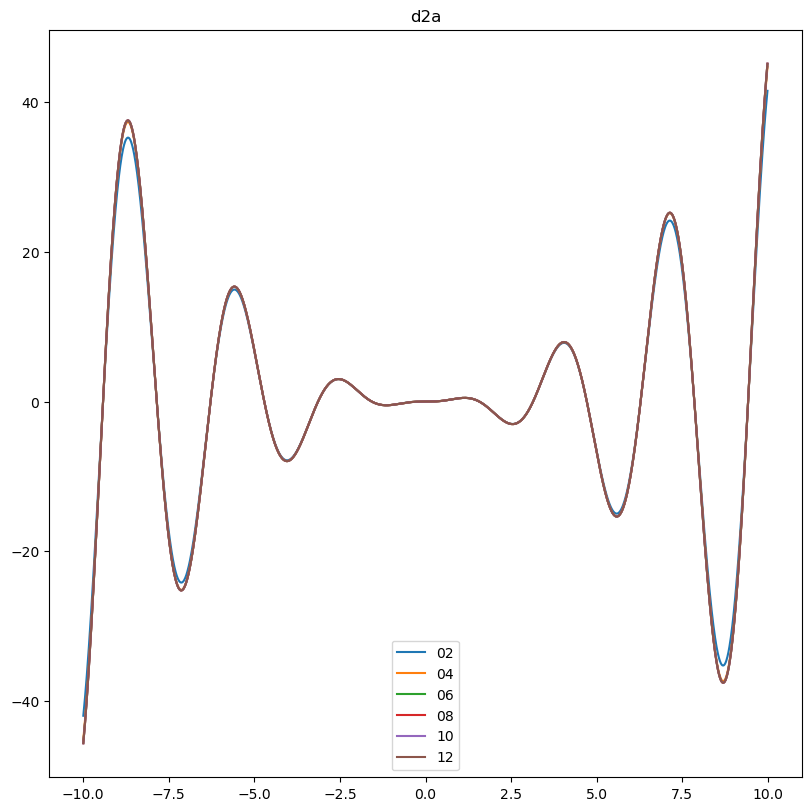

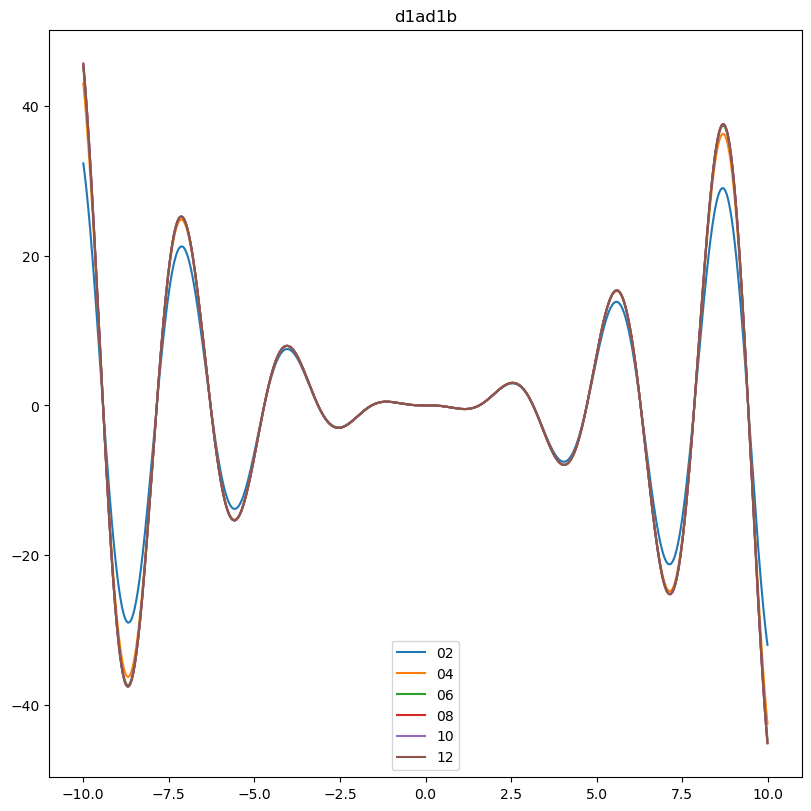

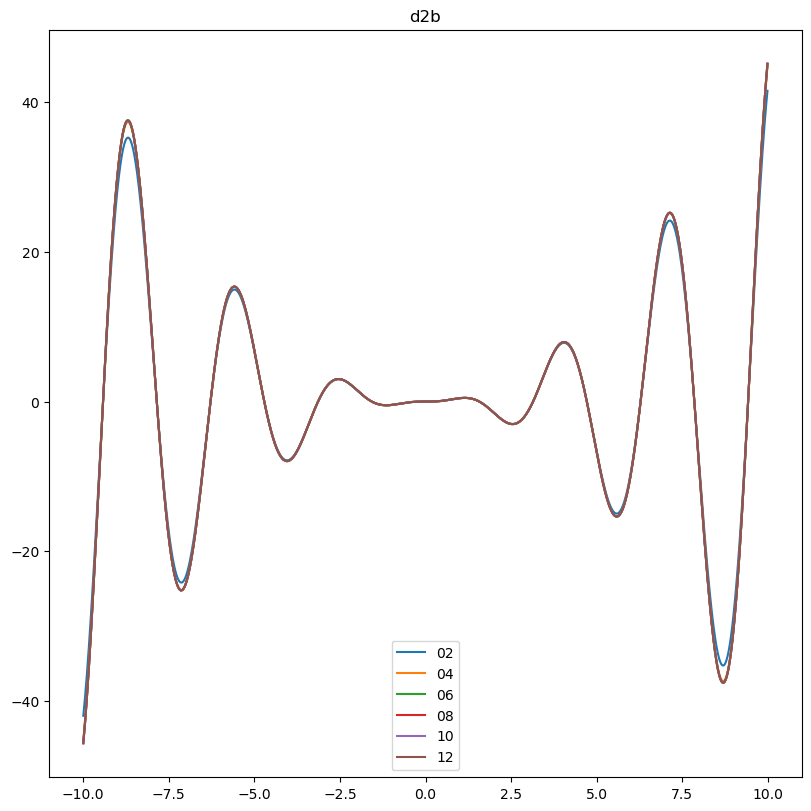

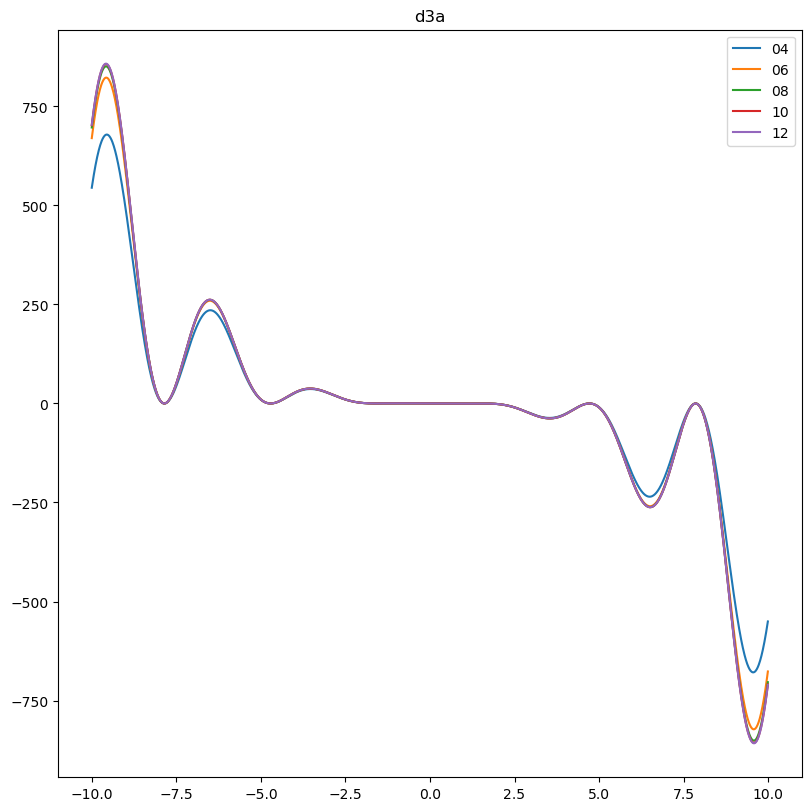

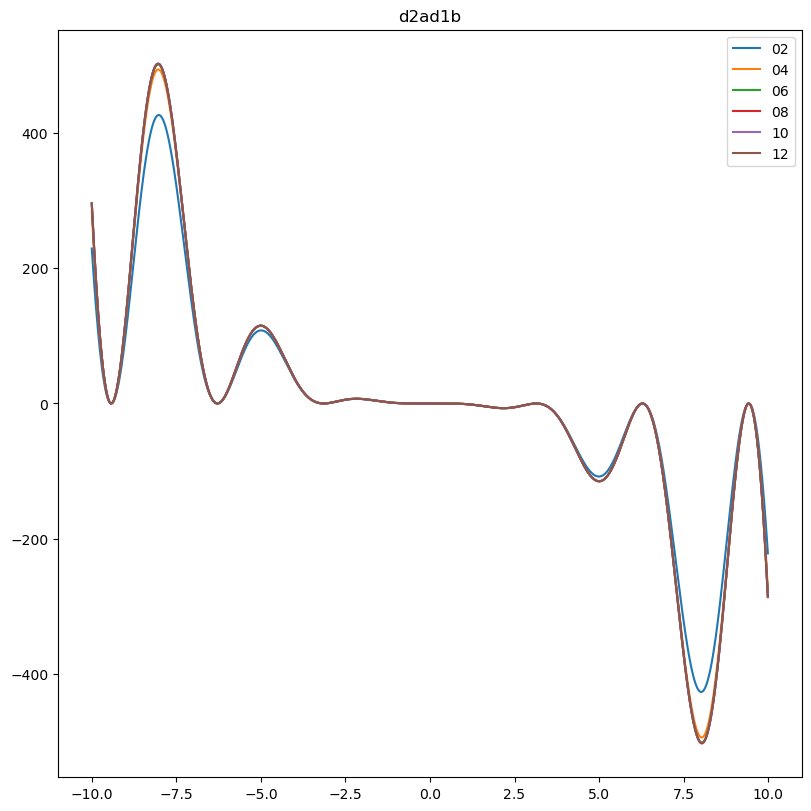

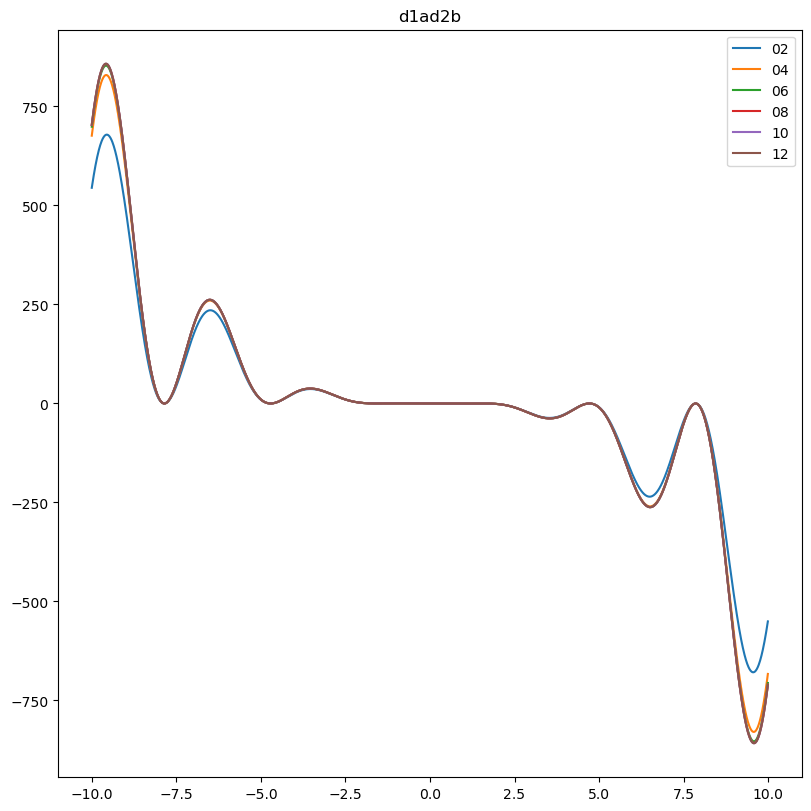

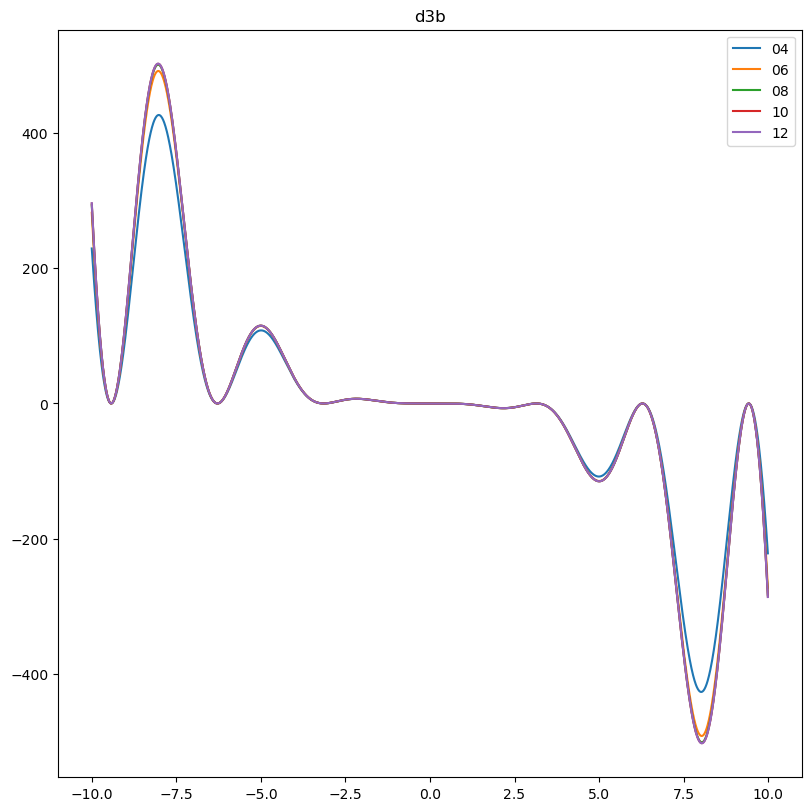

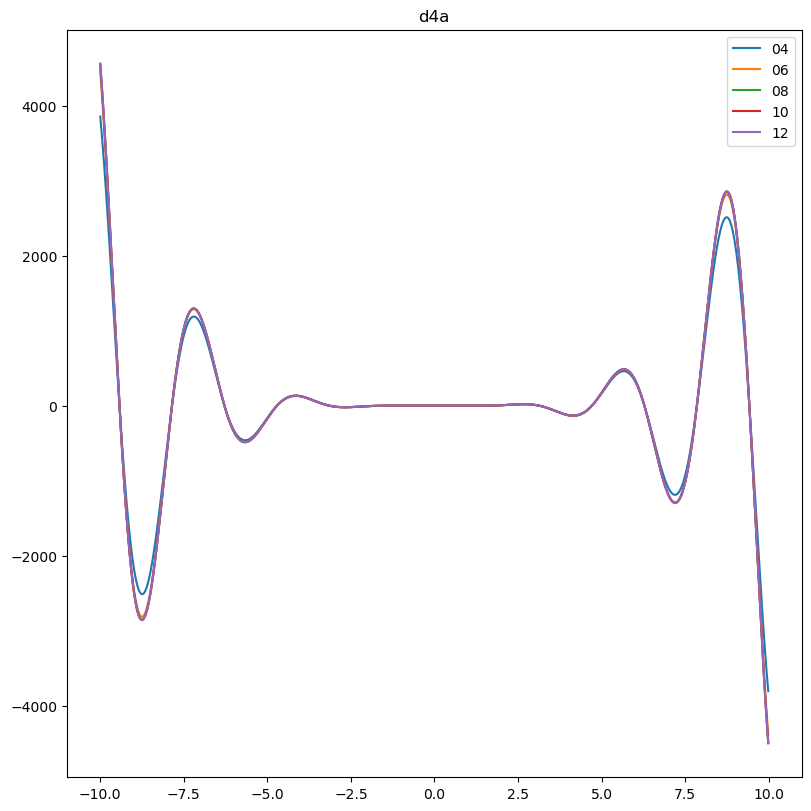

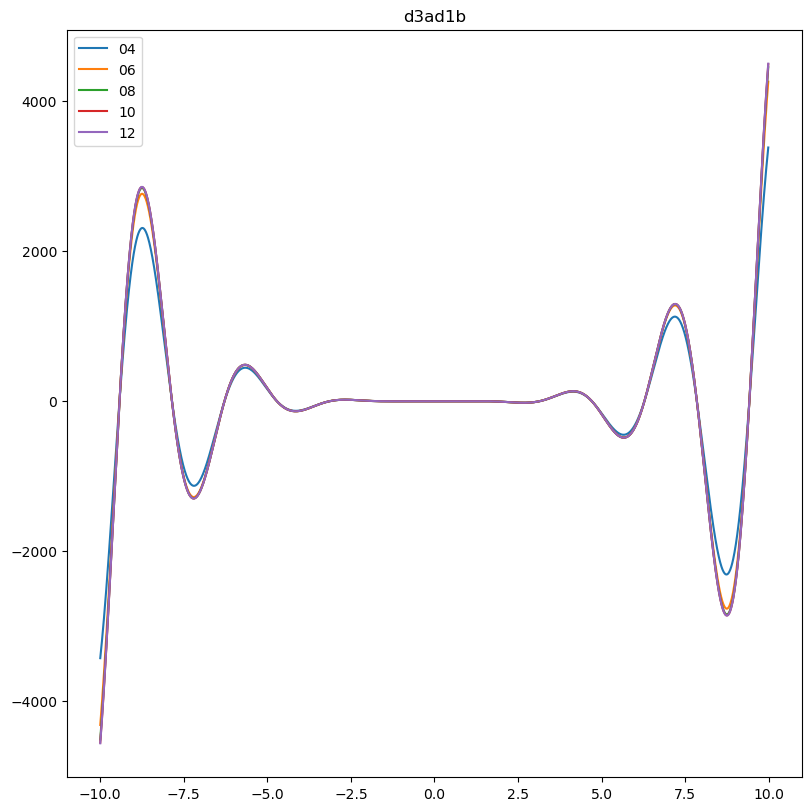

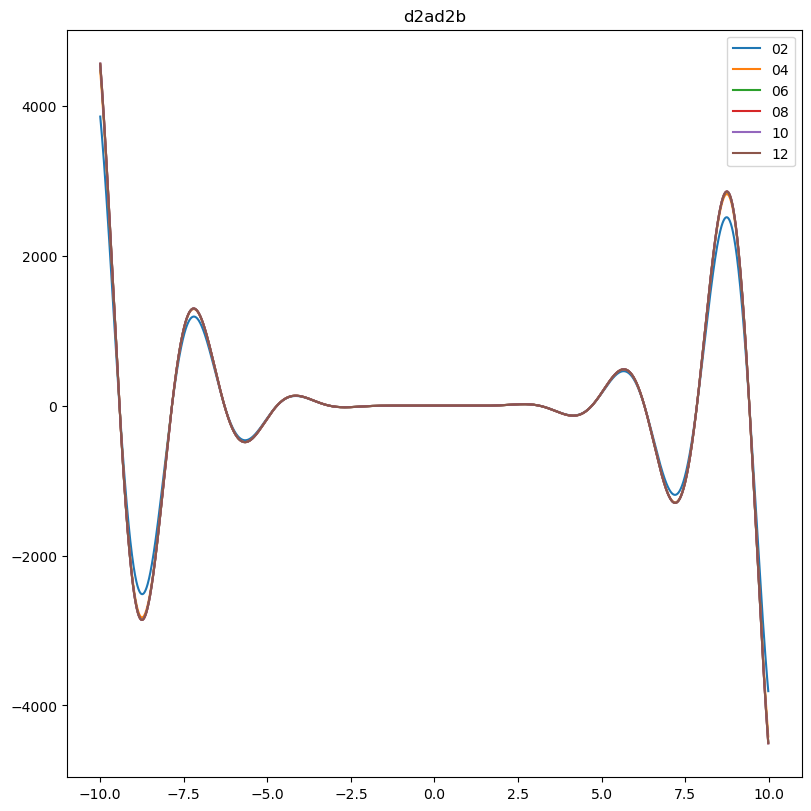

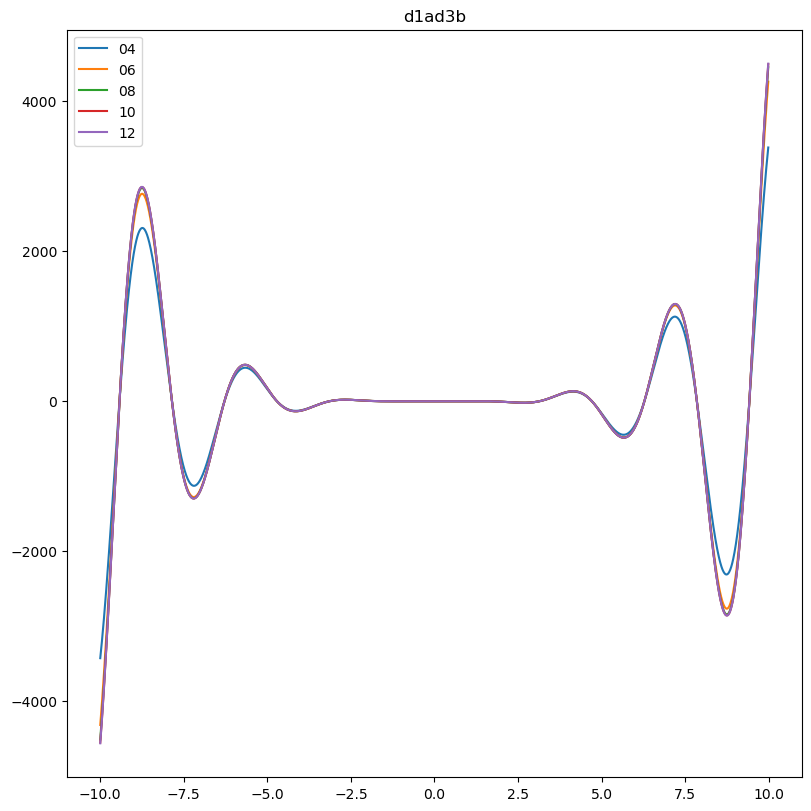

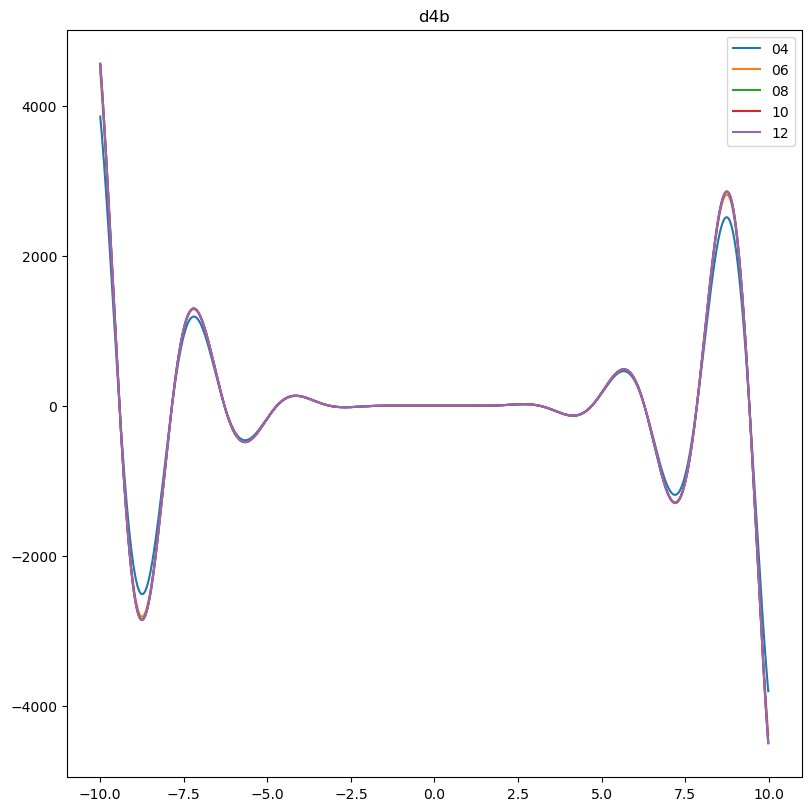

In [8]:
for this_derivative in list(ND_obj.derivatives.keys()):
    plt.figure(figsize = (8,8), constrained_layout = True)
    plt.title(this_derivative)
    for this_stencil in list(ND_obj.derivatives[this_derivative]):
        try:
            plt.plot(x_array, ND_obj.derivatives[this_derivative][this_stencil], label = this_stencil)
        except:
            pass
    plt.legend()
    plt.show()

The code will use all stencil sizes to compute all derivatives. The stencil size usually controls the precision of the derivative: a larger stencil size will lead to a more accurate derivative. The output is a dictionary with all the derivatives:

In [9]:
list(ND_obj.derivatives.keys())

['d1a',
 'd1b',
 'd2a',
 'd1ad1b',
 'd2b',
 'd3a',
 'd2ad1b',
 'd1ad2b',
 'd3b',
 'd4a',
 'd3ad1b',
 'd2ad2b',
 'd1ad3b',
 'd4b']

Each of of these entries leads to another dictionary

In [10]:
list(ND_obj.derivatives['d1a'].keys())

['02', '04', '06', '08', '10', '12']

Those inner dictionaries represent the precision (or stencil size) used to compute the derivative associated with the first key.

# 2nd example - Cosmology: linear matter power spectrum

I will use the example in the CLASS-PT website to get the linear matter power-spectrum, which is obtained by solving some complicated equations numerically.

In [11]:
from my_functions import ComputePk,kvec

In [12]:
PK = ComputePk([0.119,0.679])

Text(0, 0.5, '$k\\times P(k)$ [Mpc/$h$]$^2$')

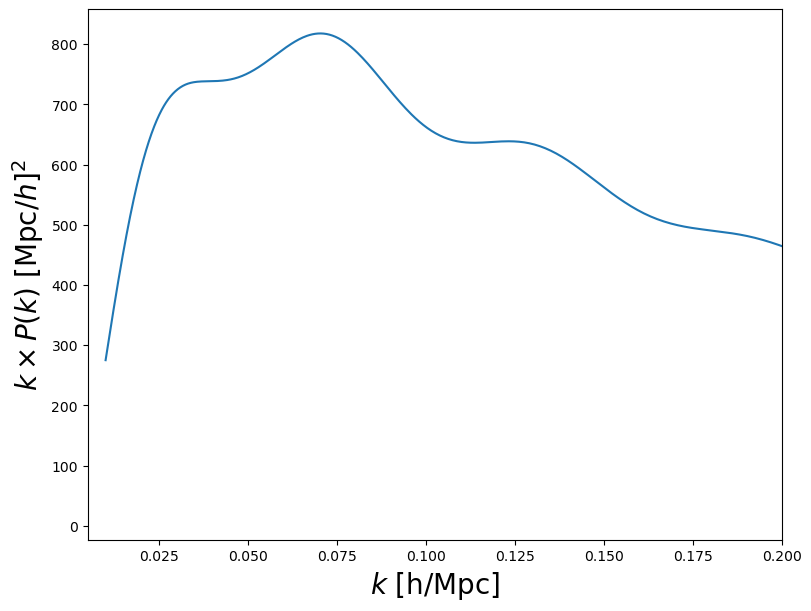

In [13]:
plt.figure(figsize = (8,6), constrained_layout= True)
plt.plot(kvec, kvec*PK)
plt.xlim((0.005,0.2))
plt.xlabel(r"$k$ [h/Mpc]", size = 20)
plt.ylabel(r"$k\times P(k)$ [Mpc/$h$]$^2$", size = 20)

Now, let's see how we can compute the derivative of the linear matter power spectrum with respect to $\omega_{\rm cdm}$ and $h$. I will do it two ways. The first one, I won't use multiprocessing.

In [14]:
ND_obj = nd.FiniteDerivative()

N_taylor = 3 #The code will compute derivatives up to this order
N_grid = 3 #The size of the stencil will be 2*N_grid + 1

expansion_table = {
    "omega_cdm":[0.1190, 0.1],
    "h":[0.678,0.1]
}

ND_obj.define_setup(N_taylor,N_grid, expansion_table)

In [15]:
start = time.time()
ND_obj.parallel = False
ND_obj.evaluate_in_grid(ComputePk)
end = time.time()
print("Time to compute the Pk in the grid without using the multiprocessing: {}".format(end-start))

Time to compute the Pk in the grid without using the multiprocessing: 408.6988000869751


In [16]:
start = time.time()
ND_obj.parallel = True
ND_obj.processes = 8
ND_obj.evaluate_in_grid(ComputePk)
end = time.time()
print("Time to compute the Pk in the grid using the multiprocessing: {}".format(end-start))

Time to compute the Pk in the grid using the multiprocessing: 94.77231907844543


In [17]:
ND_obj.take_derivative_ALL()

{'d1omega_cdm': {'02': array([-1.86732678e+05, -1.86493410e+05, -1.86245488e+05, -1.85988829e+05,
         -1.85723348e+05, -1.85448959e+05, -1.85165577e+05, -1.84873116e+05,
         -1.84571493e+05, -1.84260624e+05, -1.83940425e+05, -1.83610814e+05,
         -1.83271709e+05, -1.82923029e+05, -1.82564710e+05, -1.82196708e+05,
         -1.81818980e+05, -1.81431485e+05, -1.81034182e+05, -1.80627031e+05,
         -1.80209994e+05, -1.79783033e+05, -1.79346113e+05, -1.78899198e+05,
         -1.78442253e+05, -1.77975247e+05, -1.77498148e+05, -1.77010925e+05,
         -1.76513549e+05, -1.76005992e+05, -1.75488227e+05, -1.74960229e+05,
         -1.74421975e+05, -1.73873441e+05, -1.73314605e+05, -1.72745449e+05,
         -1.72165952e+05, -1.71576099e+05, -1.70975872e+05, -1.70365259e+05,
         -1.69744244e+05, -1.69112818e+05, -1.68470963e+05, -1.67818615e+05,
         -1.67155686e+05, -1.66482092e+05, -1.65797748e+05, -1.65102572e+05,
         -1.64396482e+05, -1.63679399e+05, -1.62951245e

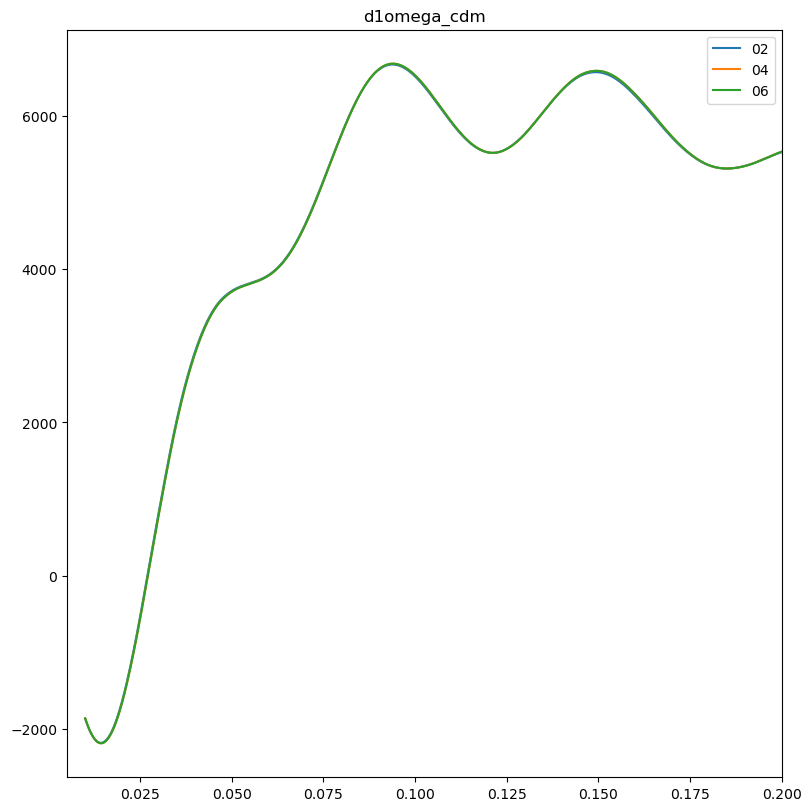

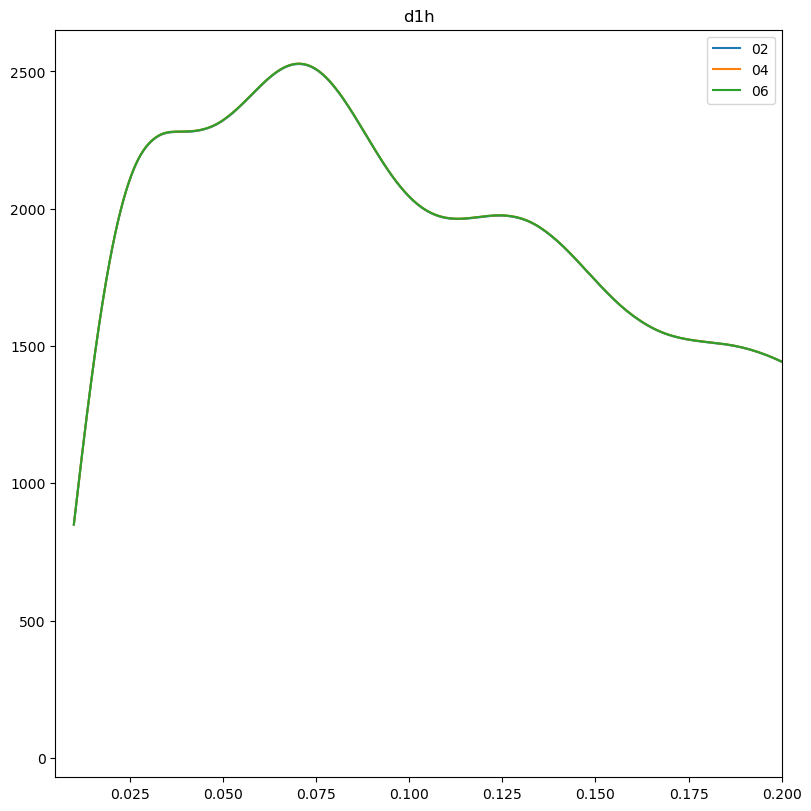

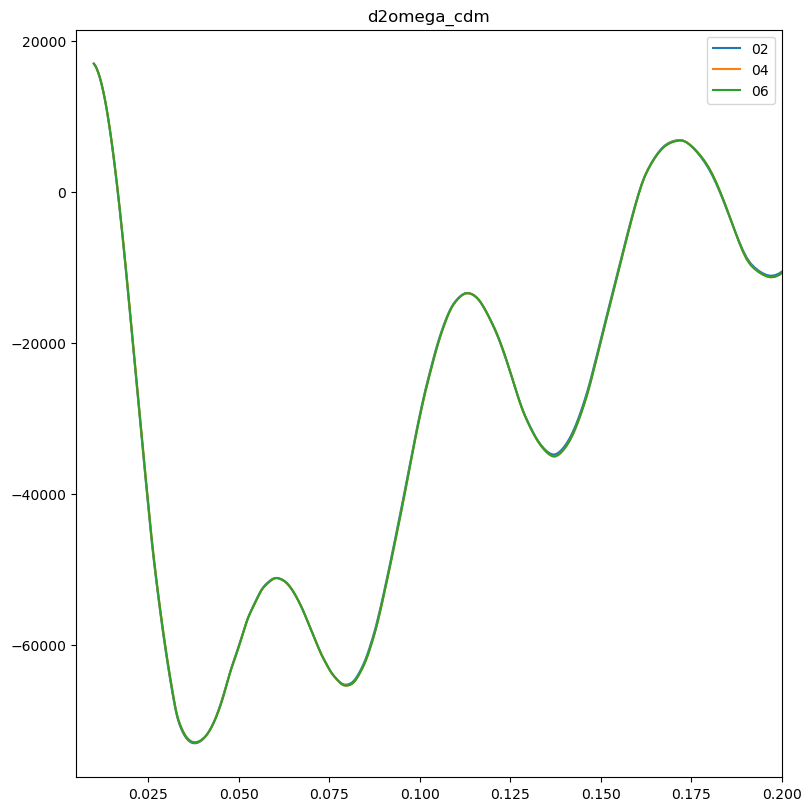

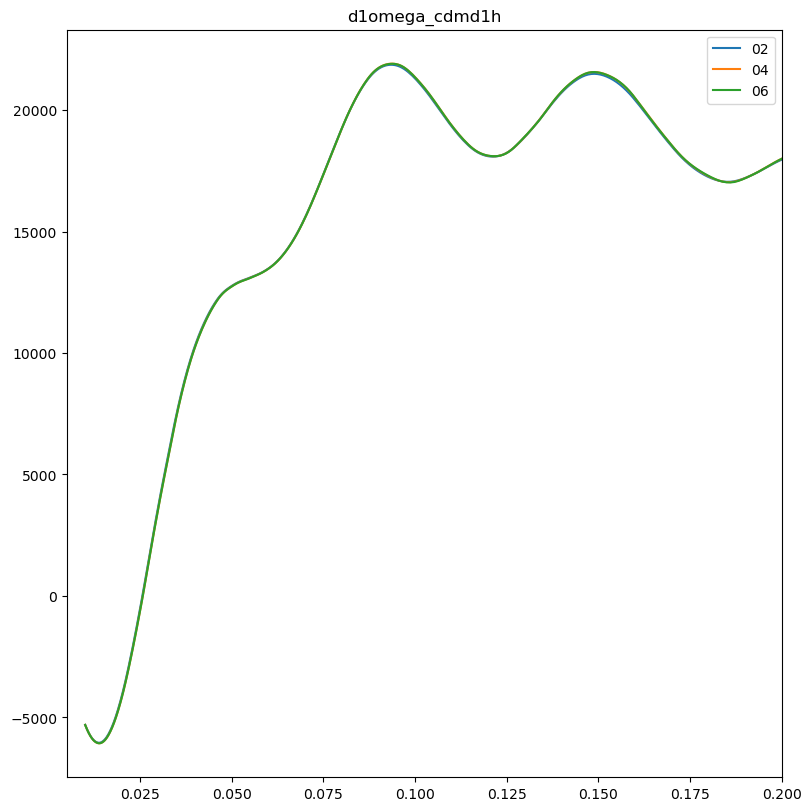

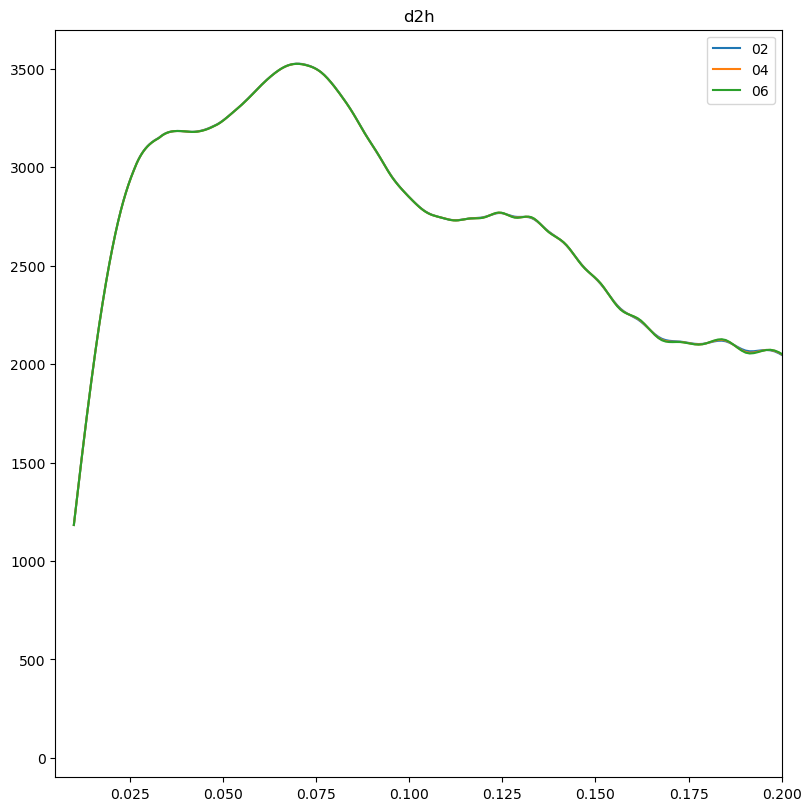

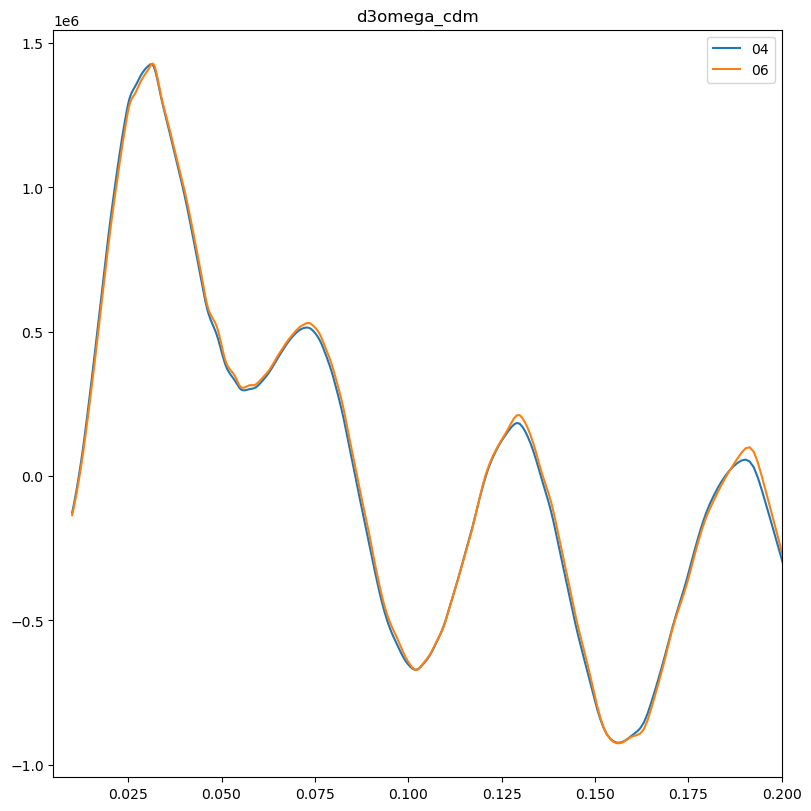

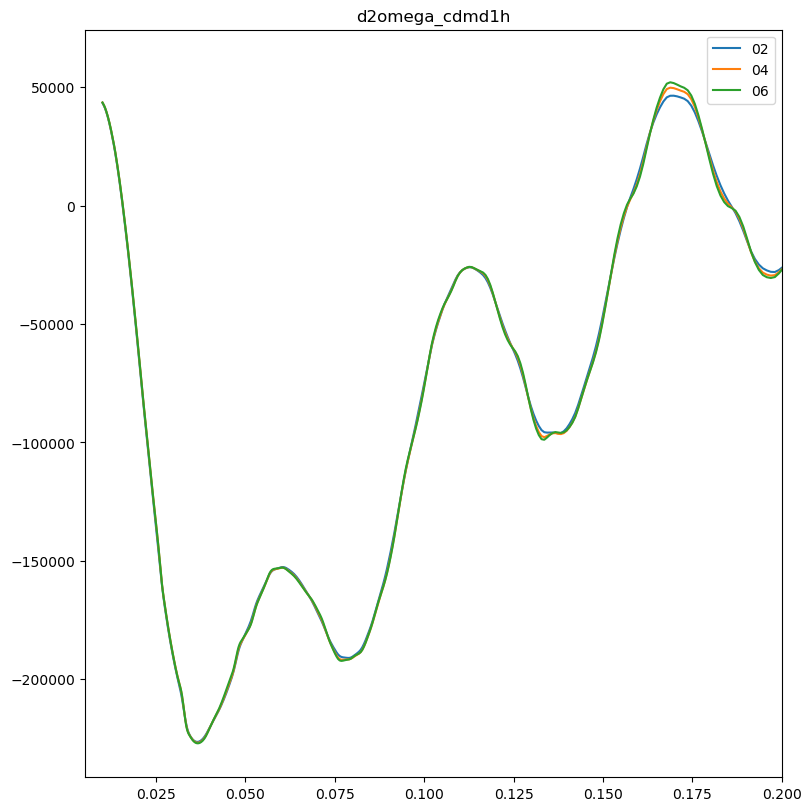

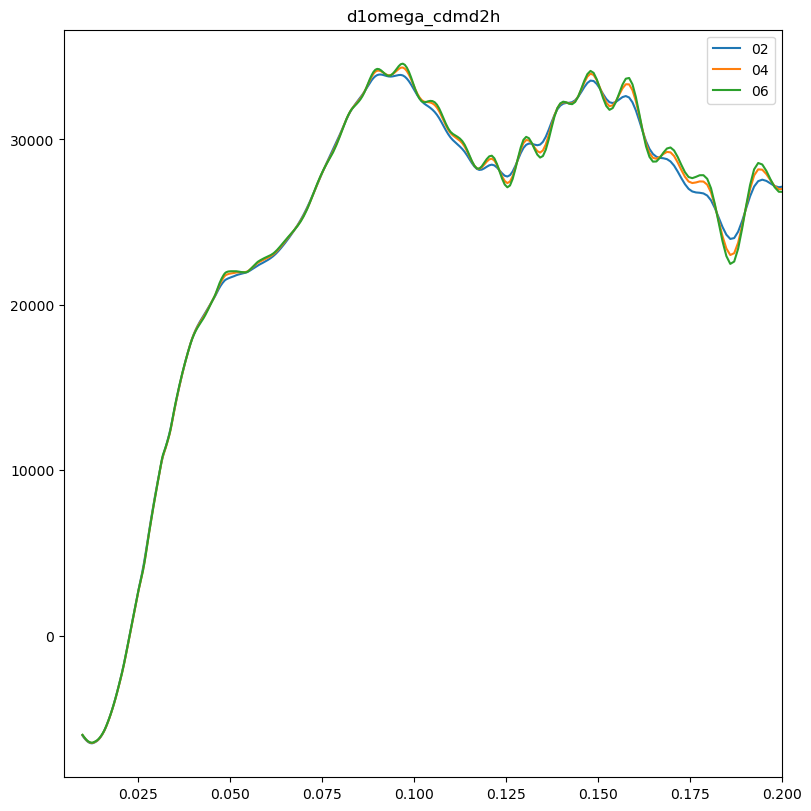

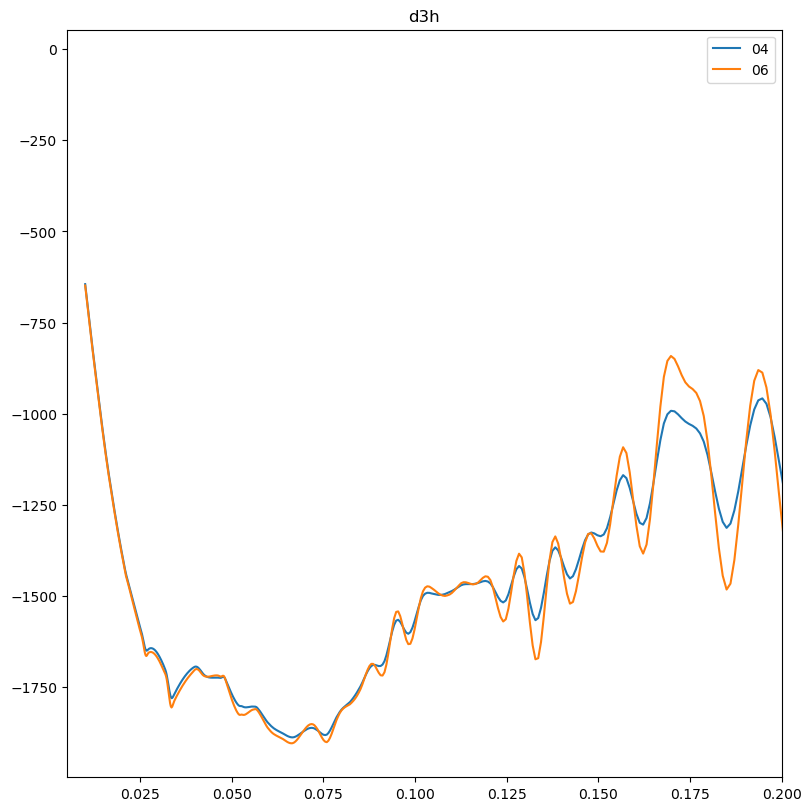

In [19]:
for this_derivative in list(ND_obj.derivatives.keys()):
    plt.figure(figsize = (8,8), constrained_layout = True)
    plt.title(this_derivative)
    for this_stencil in list(ND_obj.derivatives[this_derivative]):
        try:
            plt.plot(kvec, kvec*ND_obj.derivatives[this_derivative][this_stencil], label = this_stencil)
            plt.xlim((0.005,0.2))
        except:
            pass
    plt.legend()
    plt.show()